Implementation of GAN training framework for MNIST dataset using CNN generator and discriminator.
##[Paper](https://arxiv.org/pdf/1406.2661.pdf)

In [ ]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Using {device}")

Using cuda:0


In [ ]:
train_images = MNIST("", train=True, transform=transforms.ToTensor(), download=True)  # 28x28 size

BATCH_SIZE = 32   # Size of minibatches
LATENT_DIM = 50 # Dimension size for the random noise Z
INITIAL_MAP_SIZE = 7   # Dimension size for the initial SxS images generated from the noise

In [ ]:
### GENERATOR

class UpSampleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UpSampleConv, self).__init__()
    self.up = nn.Upsample(scale_factor=2)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    out = self.up(x)
    out = self.conv(out)
    out = self.batch_norm(out)
    out = F.relu(out)
    return out

class GenModel(nn.Module):
  def __init__(self, initial_channels=64, latent_dim=LATENT_DIM, initial_map=INITIAL_MAP_SIZE):
    super(GenModel, self).__init__()
    self.initial_map_size = initial_map
    self.initial_channels = initial_channels
    self.linear = nn.Linear(in_features=latent_dim, out_features=initial_channels * initial_map * initial_map)
    self.upsample = nn.Sequential(UpSampleConv(in_channels=initial_channels, out_channels=initial_channels), UpSampleConv(in_channels=initial_channels, out_channels=1))
  
  def forward(self, x):
    result = F.relu(self.linear(x))
    result = result.view(-1, self.initial_channels, self.initial_map_size, self.initial_map_size)

    result = self.upsample(result).squeeze(dim=1)
    
    return result


### DISCRIMINATOR

class DiscModel(nn.Module):
  def __init__(self, in_channels=1, out_classes=2):
    super(DiscModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.output = nn.Linear(in_features=8 * 7 * 7, out_features=out_classes)
  
  def forward(self, x):
    out = self.conv1(x)
    out = F.leaky_relu(self.pool(out), 0.2)

    out = self.conv2(out)
    out = F.leaky_relu(self.pool(out), 0.2)

    out = out.flatten(1)

    return self.output(out)

In [ ]:
def adversarial_train(generator, discriminator, gen_optim, disc_optim, data_loader, loss_function, latent_dim=LATENT_DIM, batch_size=BATCH_SIZE, epochs=50):
  real_label = torch.ones(batch_size).long().to(device)
  fake_label = torch.zeros(batch_size).long().to(device)
  
  evaluation_noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(device)

  gen_losses = []
  accuracies = []
  disc_fake_losses = []
  disc_valid_losses = []

  for current_epoch in range(epochs):
    start = time.time()

    gen_loss = 0
    disc_loss_valid = 0
    disc_loss_fake = 0
    all_predictions = []

    for real_images, _ in data_loader:
      # Train generator
      gen_optim.zero_grad()
      noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(device)
      gen_images = generator(noise)

      fake_data_predictions = discriminator(gen_images.unsqueeze(1))

      # Measure ability of generator to FOOL discriminator
      gen_cost = loss_function(fake_data_predictions, real_label)
      gen_cost.backward()
      gen_optim.step()

      all_predictions.extend(torch.argmax(fake_data_predictions, dim=1).cpu().numpy())

      # Train discriminator
      disc_optim.zero_grad()
      
      disc_real_cost = loss_function(discriminator(real_images.to(device)), real_label)
      disc_fake_cost = loss_function(discriminator(gen_images.unsqueeze(1).detach()), fake_label)

      disc_total_cost = disc_real_cost + disc_fake_cost
      disc_total_cost.backward()
      disc_optim.step()

      gen_loss += gen_cost.item()
      disc_loss_fake += disc_fake_cost.item()
      disc_loss_valid += disc_real_cost.item()
    
    gen_losses.append(gen_loss / len(data_loader))
    disc_fake_losses.append(disc_loss_fake / len(data_loader))
    disc_valid_losses.append(disc_loss_valid / len(data_loader))

    gen_images = generator(evaluation_noise)
    grid = make_grid(gen_images.unsqueeze(1))
    save_image(grid, f"sample_data/{current_epoch + 1}.png")

    disc_fake_accuracy = accuracy_score(np.zeros(len(all_predictions)), all_predictions)
    accuracies.append(disc_fake_accuracy)

    print(f"Epoch {current_epoch + 1} | "
          f"Accuracy {disc_fake_accuracy:.2f} | "
          f"Gen Loss {(gen_loss / len(data_loader)):.6f} | "
          f"Disc Fake Loss {(disc_loss_fake / len(data_loader)):.6f} | "
          f"Disc Valid Loss {(disc_loss_valid / len(data_loader)):.6f}| "
          f"Time {(time.time() - start):.2f} sec")

  return gen_losses, disc_fake_losses, disc_valid_losses, accuracies

In [ ]:
train_dataloader = DataLoader(train_images, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)

generator = GenModel(latent_dim=LATENT_DIM).to(device)
discriminator = DiscModel(in_channels=1).to(device)

gen_optim = torch.optim.Adam(generator.parameters(), lr=0.0002)
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

cost_function = nn.CrossEntropyLoss().to(device)

Epoch 1 | Accuracy 0.78 | Gen Loss 0.860133 | Disc Fake Loss 0.588851 | Disc Valid Loss 0.611030| Time 20.71 sec
Epoch 2 | Accuracy 0.78 | Gen Loss 0.887252 | Disc Fake Loss 0.567647 | Disc Valid Loss 0.575702| Time 20.12 sec
Epoch 3 | Accuracy 0.75 | Gen Loss 0.883320 | Disc Fake Loss 0.576282 | Disc Valid Loss 0.586335| Time 20.07 sec
Epoch 4 | Accuracy 0.78 | Gen Loss 0.956084 | Disc Fake Loss 0.542177 | Disc Valid Loss 0.554858| Time 19.91 sec
Epoch 5 | Accuracy 0.77 | Gen Loss 0.984675 | Disc Fake Loss 0.537261 | Disc Valid Loss 0.552493| Time 21.31 sec
Epoch 6 | Accuracy 0.76 | Gen Loss 0.979631 | Disc Fake Loss 0.544011 | Disc Valid Loss 0.562951| Time 20.29 sec
Epoch 7 | Accuracy 0.76 | Gen Loss 0.986963 | Disc Fake Loss 0.543973 | Disc Valid Loss 0.565281| Time 20.81 sec
Epoch 8 | Accuracy 0.76 | Gen Loss 1.007838 | Disc Fake Loss 0.534192 | Disc Valid Loss 0.558378| Time 20.45 sec
Epoch 9 | Accuracy 0.77 | Gen Loss 1.016361 | Disc Fake Loss 0.531326 | Disc Valid Loss 0.554334

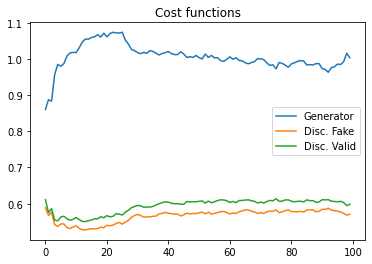

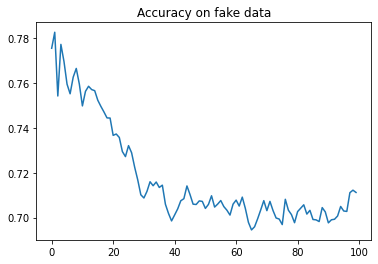

In [ ]:
N_EPOCHS = 100

gen_losses, disc_fake_losses, disc_valid_losses, accuracies = adversarial_train(generator, discriminator, gen_optim, disc_optim, train_dataloader, cost_function, epochs=N_EPOCHS)

plt.plot(range(N_EPOCHS), gen_losses, label="Generator")
plt.plot(range(N_EPOCHS), disc_fake_losses, label="Disc. Fake")
plt.plot(range(N_EPOCHS), disc_valid_losses, label="Disc. Valid")
plt.legend()
plt.title("Cost functions")
plt.show()

plt.plot(range(N_EPOCHS), accuracies)
plt.title("Accuracy on fake data")
plt.show()

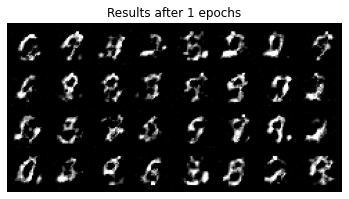

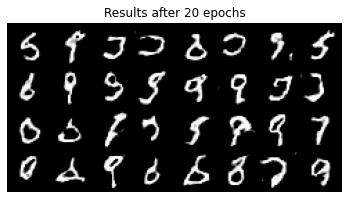

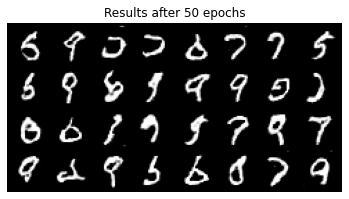

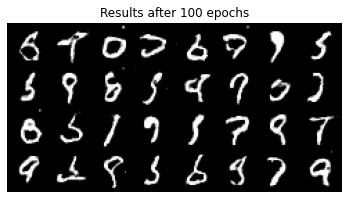

In [ ]:
image = Image.open('sample_data/1.png')
plt.imshow(image)
plt.title("Results after 1 epochs")
plt.axis('off')
plt.show()

image = Image.open('sample_data/20.png')
plt.imshow(image)
plt.title("Results after 20 epochs")
plt.axis('off')
plt.show()

image = Image.open('sample_data/50.png')
plt.imshow(image)
plt.title("Results after 50 epochs")
plt.axis('off')
plt.show()

image = Image.open('sample_data/100.png')
plt.imshow(image)
plt.title("Results after 100 epochs")
plt.axis('off')
plt.show()